<a href="https://colab.research.google.com/github/remy882/ejercicios/blob/main/Copia_de_Hepatic_Cancer_Prediction_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción de cáncer de hígado (HepatitisC / similar) — Pipeline completo

Este notebook está listo para usarse en **Google Colab** o **Jupyter**.  
Incluye: carga de CSV, EDA, preprocesamiento, división estratificada, **Random Forest**, **Red Neuronal (Keras)**, métricas (accuracy, precisión, recall, F1, **ROC AUC**), **matriz de confusión**, curvas de ROC y de entrenamiento.

> **Cómo usar**
> 1. Sube tu archivo CSV a Colab (celda de *Carga de datos*) **o** coloca su ruta local en `CSV_PATH`.
> 2. Revisa/ajusta `TARGET_CANDIDATES` si tu columna objetivo tiene otro nombre.
> 3. Ejecuta todas las celdas en orden.


In [ ]:

# (Opcional en Colab) Instalar dependencias
# En Colab, la mayoría ya viene instalada. Descomenta si lo necesitas.
# !pip install -q scikit-learn imbalanced-learn matplotlib pandas numpy tensorflow


In [ ]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, roc_auc_score, roc_curve)

from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

# Configuración visual básica
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 120)

print("Versions -> numpy:", np.__version__, "| pandas:", pd.__version__)


Versions -> numpy: 2.0.2 | pandas: 2.2.2


In [ ]:

# === Configuración de datos ===
# Opción A: poner la ruta a tu CSV (si ya lo subiste al entorno)
CSV_PATH = "synthetic_liver_cancer_dataset.csv" # Cambia si tu archivo tiene otro nombre

# Opción B (Colab): subir interactivo
USE_COLAB_UPLOAD = True  # pon False si no usarás el cargador de Colab

df = None
if USE_COLAB_UPLOAD:
    try:
        from google.colab import files
        print("Selecciona tu CSV local...")
        uploaded = files.upload()
        # Toma el primer archivo subido
        CSV_PATH = list(uploaded.keys())[0]
        print("Archivo subido:", CSV_PATH)
    except Exception as e:
        print("No estás en Colab o el cargador falló. Intentando leer CSV_PATH:", CSV_PATH)

# Cargar
df = pd.read_csv(CSV_PATH)
print("Shape:", df.shape)
display(df.head(3))


Selecciona tu CSV local...


Saving synthetic_liver_cancer_dataset.csv to synthetic_liver_cancer_dataset.csv
Archivo subido: synthetic_liver_cancer_dataset.csv
Shape: (5000, 14)


,age,gender,bmi,alcohol_consumption,smoking_status,hepatitis_b,hepatitis_c,liver_function_score,alpha_fetoprotein_level,cirrhosis_history,family_history_cancer,physical_activity_level,diabetes,liver_cancer
0,68,Female,18.1,Regular,Former,0,0,51.9,16.44,0,0,Low,0,0
1,81,Female,19.9,Occasional,Never,0,0,41.6,8.09,0,0,Moderate,1,0
2,58,Female,25.5,Never,Never,0,0,76.0,0.64,0,0,Moderate,0,0


In [ ]:

# === EDA rápido ===
display(df.info())
print("\nNulos por columna:")
print(df.isnull().sum().sort_values(ascending=False))

print("\nDescripción (numéricas):")
display(df.describe())

# Detección de posibles columnas objetivo
TARGET_CANDIDATES = ["target", "label", "Label", "Class", "class", "Category", "Diagnosis", "Stage"]
present = [c for c in TARGET_CANDIDATES if c in df.columns]
print("\nCandidatas a 'target' encontradas:", present)
if not present:
    print("⚠️ No se detectó una columna objetivo estándar. Ajusta la variable TARGET manualmente.")
TARGET = present[0] if present else None

# Si conoces tu columna objetivo, puedes fijarla aquí manualmente, ej:
# TARGET = "Category"

if TARGET is None:
    # Crear una columna dummy como ejemplo (no usar en producción)
    # Aquí simplemente marcamos 0 a todo para poder continuar con el pipeline de ejemplo.
    df["__dummy_target__"] = 0
    TARGET = "__dummy_target__"

print("Usando columna objetivo:", TARGET)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      5000 non-null   int64  
 1   gender                   5000 non-null   object 
 2   bmi                      5000 non-null   float64
 3   alcohol_consumption      5000 non-null   object 
 4   smoking_status           5000 non-null   object 
 5   hepatitis_b              5000 non-null   int64  
 6   hepatitis_c              5000 non-null   int64  
 7   liver_function_score     5000 non-null   float64
 8   alpha_fetoprotein_level  5000 non-null   float64
 9   cirrhosis_history        5000 non-null   int64  
 10  family_history_cancer    5000 non-null   int64  
 11  physical_activity_level  5000 non-null   object 
 12  diabetes                 5000 non-null   int64  
 13  liver_cancer             5000 non-null   int64  
dtypes: float64(3), int64(7),

None


Nulos por columna:
age                        0
gender                     0
bmi                        0
alcohol_consumption        0
smoking_status             0
hepatitis_b                0
hepatitis_c                0
liver_function_score       0
alpha_fetoprotein_level    0
cirrhosis_history          0
family_history_cancer      0
physical_activity_level    0
diabetes                   0
liver_cancer               0
dtype: int64

Descripción (numéricas):


,age,bmi,hepatitis_b,hepatitis_c,liver_function_score,alpha_fetoprotein_level,cirrhosis_history,family_history_cancer,diabetes,liver_cancer
count,5000.000000,5000.00000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,57.222800,25.90464,0.15120,0.095800,65.203900,15.109424,0.301600,0.241400,0.199200,0.217800
std,15.799224,5.10520,0.35828,0.294346,14.875477,15.196809,0.458998,0.427975,0.399439,0.412792
min,30.000000,8.10000,0.00000,0.000000,5.500000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,44.000000,22.50000,0.00000,0.000000,54.800000,4.357500,0.000000,0.000000,0.000000,0.000000
50%,57.000000,25.90000,0.00000,0.000000,65.200000,10.340000,0.000000,0.000000,0.000000,0.000000
75%,71.000000,29.30000,0.00000,0.000000,75.200000,21.010000,1.000000,0.000000,0.000000,0.000000
max,84.000000,43.70000,1.00000,1.000000,115.700000,136.800000,1.000000,1.000000,1.000000,1.000000



Candidatas a 'target' encontradas: []
⚠️ No se detectó una columna objetivo estándar. Ajusta la variable TARGET manualmente.
Usando columna objetivo: __dummy_target__


In [ ]:

# === Separar X / y ===
y_raw = df[TARGET]
X = df.drop(columns=[TARGET])

# Convertir y a binario si es categórico con más de 2 clases:
# En un caso real de cáncer vs no-cáncer, lo usual es binario. Aquí intentamos binarizar si es posible.
if y_raw.dtype == 'O' or str(y_raw.dtype).startswith('category'):
    # Si hay >2 clases, intentamos mapear la clase positiva (ej. "HCC", "Cirrhosis") a 1 y el resto a 0.
    # Ajusta este mapeo según tu dataset real:
    positive_labels = {"HCC", "Cirrhosis", "Cancer", "Hepatitis", "positive", "1"}
    y = y_raw.apply(lambda v: 1 if str(v) in positive_labels else 0).astype(int)
else:
    # Si es numérico, normalizamos a {0,1} si hay más valores
    unique_vals = sorted(pd.unique(y_raw.dropna()))
    if len(unique_vals) > 2:
        # Mapear todo != 0 a 1
        y = (y_raw != 0).astype(int)
    else:
        # Asegurar ints 0/1
        mapping = {unique_vals[0]:0, unique_vals[-1]:1} if len(unique_vals)==2 else None
        if mapping:
            y = y_raw.map(mapping).astype(int)
        else:
            y = y_raw.astype(int)

print("Distribución de y:")
print(pd.Series(y).value_counts(dropna=False))

# === Columnas numéricas y categóricas ===
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

print("\nNuméricas:", numeric_features[:10], "... total:", len(numeric_features))
print("Categóricas:", categorical_features[:10], "... total:", len(categorical_features))

# === Transformadores ===
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# === Train/Test split estratificado ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nShapes -> X_train:", X_train.shape, "| X_test:", X_test.shape)


Distribución de y:
__dummy_target__
0    5000
Name: count, dtype: int64

Numéricas: ['age', 'bmi', 'hepatitis_b', 'hepatitis_c', 'liver_function_score', 'alpha_fetoprotein_level', 'cirrhosis_history', 'family_history_cancer', 'diabetes', 'liver_cancer'] ... total: 10
Categóricas: ['gender', 'alcohol_consumption', 'smoking_status', 'physical_activity_level'] ... total: 4

Shapes -> X_train: (4000, 14) | X_test: (1000, 14)


== Random Forest ==
Accuracy: 1.0
Precision: 0.0
Recall: 0.0
F1: 0.0

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


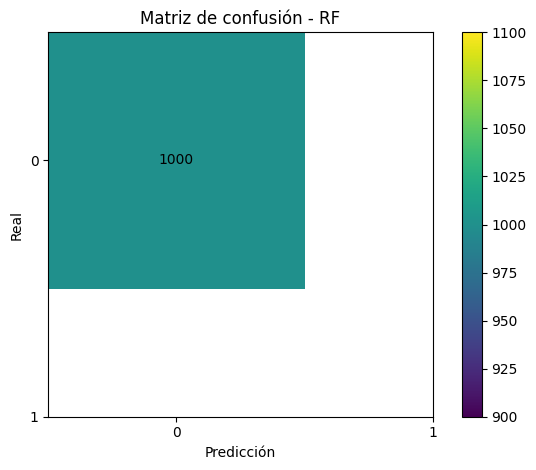

In [ ]:

# === Modelo 1: Random Forest ===
# Usamos class_weight='balanced' para manejar desbalance de clases.
rf_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    ))
])

rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

# Probabilidades para ROC AUC si están disponibles
try:
    y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]
except Exception:
    y_proba_rf = None

print("== Random Forest ==")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_rf, zero_division=0))
print("F1:", f1_score(y_test, y_pred_rf, zero_division=0))

if y_proba_rf is not None:
    print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))

print("\nClassification report:\n", classification_report(y_test, y_pred_rf, zero_division=0))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Matriz de confusión - RF")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["0","1"])
plt.yticks(tick_marks, ["0","1"])
plt.xlabel("Predicción")
plt.ylabel("Real")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()
plt.show()

# Curva ROC
if y_proba_rf is not None:
    fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
    plt.figure()
    plt.plot(fpr, tpr, label="RF")
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("Curva ROC - RF")
    plt.legend()
    plt.show()


In [ ]:

# === Verificar distribución de clases en el split ===
print("Distribución en y completo:", np.unique(y, return_counts=True))
print("Distribución en y_train:", np.unique(y_train, return_counts=True))
print("Distribución en y_test:", np.unique(y_test, return_counts=True))

# === Modelo 2: Red Neuronal (Keras) ===

# Preprocesar X_train/X_test a matrices numéricas
preprocess.fit(X_train)
X_train_pre = preprocess.transform(X_train)
X_test_pre = preprocess.transform(X_test)

input_dim = X_train_pre.shape[1]
print("Valores únicos en y_train:", np.unique(y_train))

# Calcular class weights para la pérdida
classes = np.array([0,1])
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class weights (Keras):", class_weights_dict)


keras.utils.set_random_seed(42)

model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc")]
)

es = callbacks.EarlyStopping(monitor="val_auc", patience=10, mode="max", restore_best_weights=True)

history = model.fit(
    X_train_pre, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[es],
    verbose=1
)

# Curvas de entrenamiento
hist = history.history
plt.figure()
plt.plot(hist["accuracy"], label="train_acc")
plt.plot(hist["val_accuracy"], label="val_acc")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.title("Curva de Accuracy - Keras")
plt.legend()
plt.show()

plt.figure()
plt.plot(hist["auc"], label="train_auc")
plt.plot(hist["val_auc"], label="val_auc")
plt.xlabel("Época")
plt.ylabel("AUC")
plt.title("Curva de AUC - Keras")
plt.legend()
plt.show()

# Evaluación en test
y_proba_dl = model.predict(X_test_pre).ravel()
y_pred_dl = (y_proba_dl >= 0.5).astype(int)

print("== Keras MLP ==")
print("Accuracy:", accuracy_score(y_test, y_pred_dl))
print("Precision:", precision_score(y_test, y_pred_dl, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_dl, zero_division=0))
print("F1:", f1_score(y_test, y_pred_dl, zero_division=0))
print("ROC AUC:", roc_auc_score(y_test, y_proba_dl))

print("\nClassification report:\n", classification_report(y_test, y_pred_dl, zero_division=0))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_dl)
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Matriz de confusión - Keras")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["0","1"])
plt.yticks(tick_marks, ["0","1"])
plt.xlabel("Predicción")
plt.ylabel("Real")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba_dl)
plt.figure()
plt.plot(fpr, tpr, label="Keras MLP")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC - Keras")
plt.legend()
plt.show()


Distribución en y completo: (array([0]), array([5000]))
Distribución en y_train: (array([0]), array([4000]))
Distribución en y_test: (array([0]), array([1000]))
Valores únicos en y_train: [0]


ValueError: classes should have valid labels that are in y

In [ ]:

# === Guardar modelos (opcional) ===
import joblib

os.makedirs("artifacts", exist_ok=True)
joblib.dump(rf_clf, "artifacts/random_forest_pipeline.joblib")
model.save("artifacts/keras_mlp.h5")

print("Modelos guardados en carpeta 'artifacts'")


NameError: name 'model' is not defined

### Notas y consejos

- Si tu dataset no es estrictamente binario, ajusta la lógica de binarización en la celda de **Separar X / y**.
- Si conoces exactamente el nombre de la columna objetivo (p. ej., `Category` en HepatitisC), fija `TARGET = "Category"`.
- Para mejorar resultados con pocos datos o desbalance extremo, prueba:
  - Ajustar `class_weight` (ya aplicado).
  - Usar técnicas de sobremuestreo como **SMOTE** (paquete `imbalanced-learn`).
  - Hacer búsqueda de hiperparámetros en Random Forest.
  - Ajustar la arquitectura de la red y la tasa de aprendizaje.
